In [1]:
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Load the dataset
Penser à ajouter le fichier /data au .gitignore

In [2]:
BATCH_SIZE = 128
IMG_SIZE = 28
print(torch.__version__)
data_transforms = [
    # transforms.Pad(padding=2),
    transforms.ToTensor(), # Scales data into [0,1] 
    transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    # transforms.Resize(IMG_SIZE)
]
data_transform = transforms.Compose(data_transforms)
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)
print(mnist_trainset)
print(mnist_testset)
print(mnist_trainset.data.size())
data = torch.utils.data.ConcatDataset([mnist_trainset, mnist_testset])

1.12.1+cu113


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )
torch.Size([60000, 28, 28])


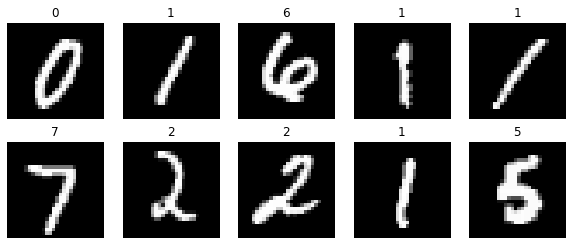

In [3]:
figure = plt.figure(figsize=(10, 4))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_trainset), size=(1,)).item()
    img, label = mnist_trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Forward noise

In [5]:
import torch.nn.functional as F

Text(0, 0.5, 'alpha_cumprod')

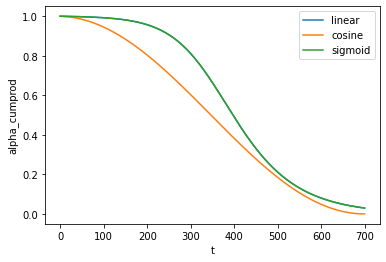

In [6]:
def linear_beta_schedule(timesteps, start=0.00001, end=0.02):
    return torch.linspace(start, end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.00001, 0.9999)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.00001
    beta_end = 0.01
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 700
betas = sigmoid_beta_schedule(timesteps=T) #linear_beta_schedule(timesteps=T)
# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
plt.plot(alphas_cumprod, label="linear")
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

betas_c = cosine_beta_schedule(timesteps=T) #linear_beta_schedule(timesteps=T)
# Pre-calculate different terms for closed form
alphas_c = 1. - betas_c
alphas_cumprod_c = torch.cumprod(alphas_c, axis=0)
plt.plot(alphas_cumprod_c, label="cosine")
alphas_cumprod_prev_c = F.pad(alphas_cumprod_c[:-1], (1, 0), value=1.0)
sqrt_recip_alphas_c = torch.sqrt(1.0 / alphas_c)
sqrt_alphas_cumprod_c = torch.sqrt(alphas_cumprod_c)
sqrt_one_minus_alphas_cumprod_c = torch.sqrt(1. - alphas_cumprod_c)
posterior_variance_c = betas_c * (1. - alphas_cumprod_prev_c) / (1. - alphas_cumprod_c)

betas_s = sigmoid_beta_schedule(timesteps=T) #linear_beta_schedule(timesteps=T)
# Pre-calculate different terms for closed form
alphas_s = 1. - betas_s
alphas_sumprod_s = torch.cumprod(alphas_s, axis=0)
plt.plot(alphas_sumprod_s, label="sigmoid")
alphas_sumprod_prev_s = F.pad(alphas_sumprod_s[:-1], (1, 0), value=1.0)
sqrt_recip_alphas_s = torch.sqrt(1.0 / alphas_s)
sqrt_alphas_sumprod_s = torch.sqrt(alphas_sumprod_s)
sqrt_one_minus_alphas_sumprod_s = torch.sqrt(1. - alphas_sumprod_s)
posterior_variance_s = betas_s * (1. - alphas_sumprod_prev_s) / (1. - alphas_sumprod_s)

plt.legend()
plt.xlabel("t")
plt.ylabel("alpha_cumprod")

In [7]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image), cmap='Greys_r')

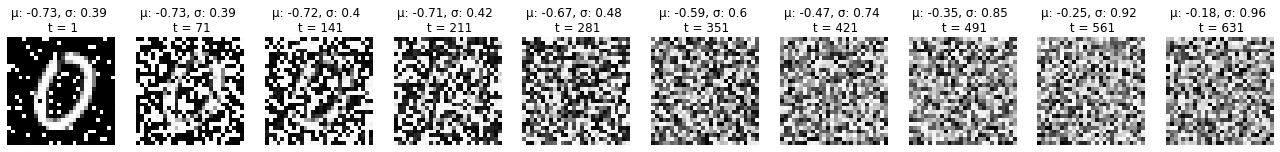

In [8]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]
plt.figure(figsize=(25,15))
num_images = 10
bins = 20
stepsize = int(T/num_images)
flattens = []
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    noised_image, noise = forward_diffusion_sample(image, t)
    (sigma, mu) = torch.var_mean(noised_image)
    flat = torch.flatten(noised_image)
    flattens.append(flat)
    title = 'μ: {}, σ: {} \n t = {}'.format(float(f'{mu.item():.2f}'), float(f'{sigma.item():.2f}'), idx+1)
    plt.title(title)
    show_tensor_image(noised_image)
    plt.axis('off')

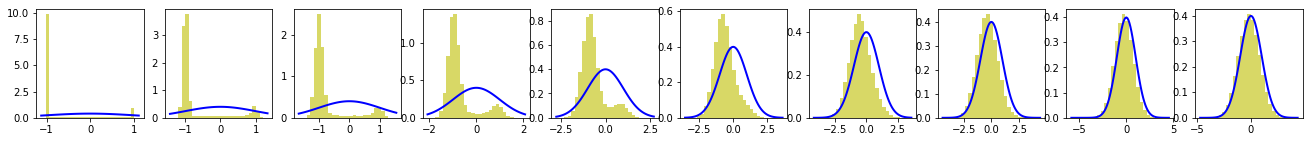

In [9]:
from scipy.stats import norm
plt.figure(figsize=(25,2))
for i, flat in enumerate(flattens):
  plt.subplot(1, num_images+1, i + 1)
  plt.hist(flat, bins=25, density=True, alpha=0.6, color='y')
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, 0, 1)
  plt.plot(x, p, 'b', linewidth=2)

In [ ]:
greek_letterz=[chr(code) for code in range(945,970)]

print(greek_letterz)

['α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω']


In [10]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        k=4
        s=2
        p=2 
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1) # 2*in_ch because we concat the residual input
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=k, stride=s, padding=p)
            self.transform2 = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=3, stride=s, padding=1)
        else: #down
          self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
          self.transform = nn.Conv2d(out_ch, out_ch, kernel_size=k, stride=s, padding=p)
          self.transform2 = self.transform # we don't need to adapt the padding for the downsampling
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        
        if x.shape[-1]==3 or x.shape[-1]==8:
            return self.transform2(h)
        else:
            return self.transform(h)
            '''
        return self.transform(h)'''


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 1, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  65572001


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (transform2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (con

# LOSS

In [11]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise, noise_pred)

# SAMPLING

In [43]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 1, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(num_images - i/stepsize))
            plt.title('t = {}'.format(i))
            img = torch.clamp(img, 0, 1) # NEW
            show_tensor_image(img.detach().cpu())
    plt.show()            

# TRAINING & VISUALIZATION

In [14]:
from google.colab import drive
# connect to drive
drive.mount('/content/drive')
!ls
import os
os.chdir('drive/MyDrive/IASD/DS/Diffusion')

Mounted at /content/drive
data  drive  model.pth	sample_data


Epoch 0 | step 000 Loss: 0.057831455022096634 


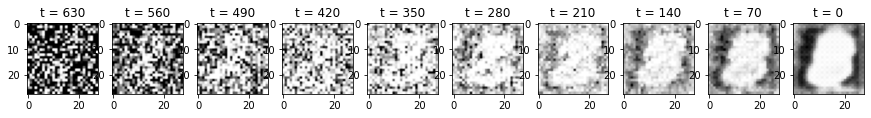

Epoch 0 | step 100 Loss: 0.05484448000788689 


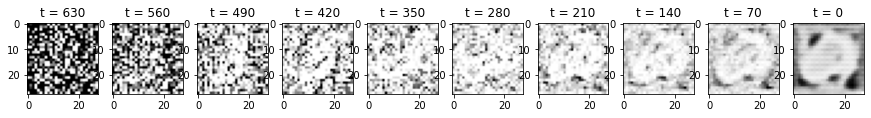

Epoch 0 | step 200 Loss: 0.05362048000097275 


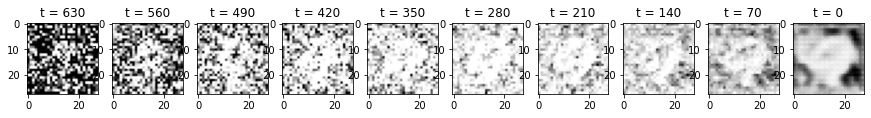

Epoch 0 | step 300 Loss: 0.05767018347978592 


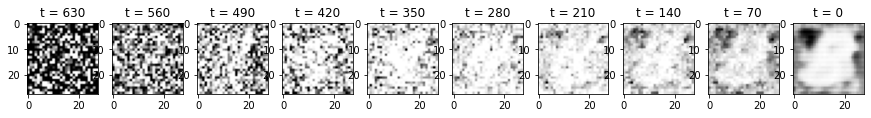

Epoch 0 | step 400 Loss: 0.06002813205122948 


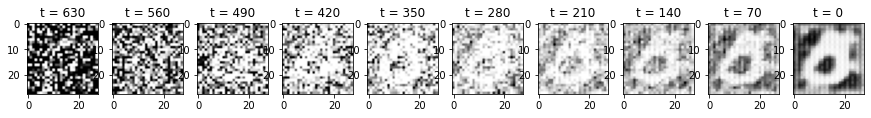

Epoch 0 | step 500 Loss: 0.05109569802880287 


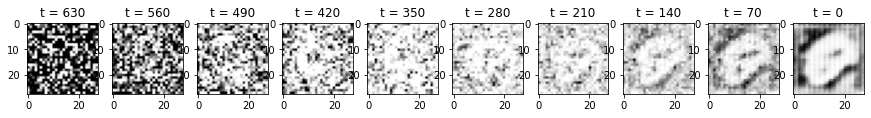

In [44]:
from torch.optim import Adam, SGD

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 1 # Try more!
PATH = 'model.pth'

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 1 == 0 and step % 100 == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()
        torch.save(model.state_dict(), PATH)

In [ ]:
t = torch.full((1,), 0, device=device, dtype=torch.long)
img = sample_timestep(img, t)
img = torch.clamp(img, 0, 1)
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
show_tensor_image(img)

In [18]:
from tqdm import trange

Generated: 100%|██████████| 1/1 [00:05<00:00,  5.75s/img]


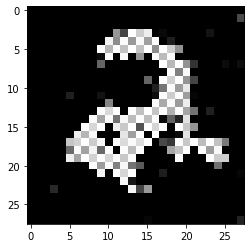

In [61]:
@torch.no_grad()
def sample_timestep2(model, x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model2(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

def load_model(model):
    state = torch.load('model.pth', map_location=torch.device(device))
    model.load_state_dict(state)
    return model

model2 = SimpleUnet().cuda()
model2 = load_model(model2)

with trange(1, desc="Generated", unit="img") as te:
    for idx in te:
        img = torch.randn((1, 1, 28, 28), device=device)
        for i in range(0,T)[::-1]:
            t = torch.full((1,), i, device=device, dtype=torch.long)
            img = sample_timestep2(model2, img, t)
        img = torch.clamp(img, 0, 1) # NEW
        torchvision.utils.save_image(img, os.path.join('samples', f'{idx}.png'))
        show_tensor_image(img.detach().cpu())